In [8]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
from fastdtw import dtw

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)


################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols
from scripts.variables import df_names, df_names_with_mis

############# Load in dfs scaled ###############
dfs = {}
for name in df_names:
    dfs[name] = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))




----------------v1_day----------------


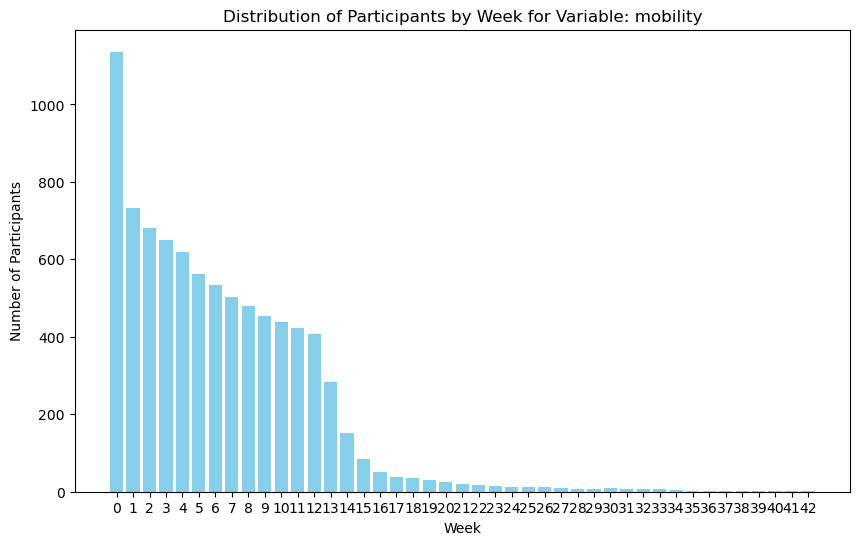

weeks found: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Filtered DataFrame shape: (1136, 44)


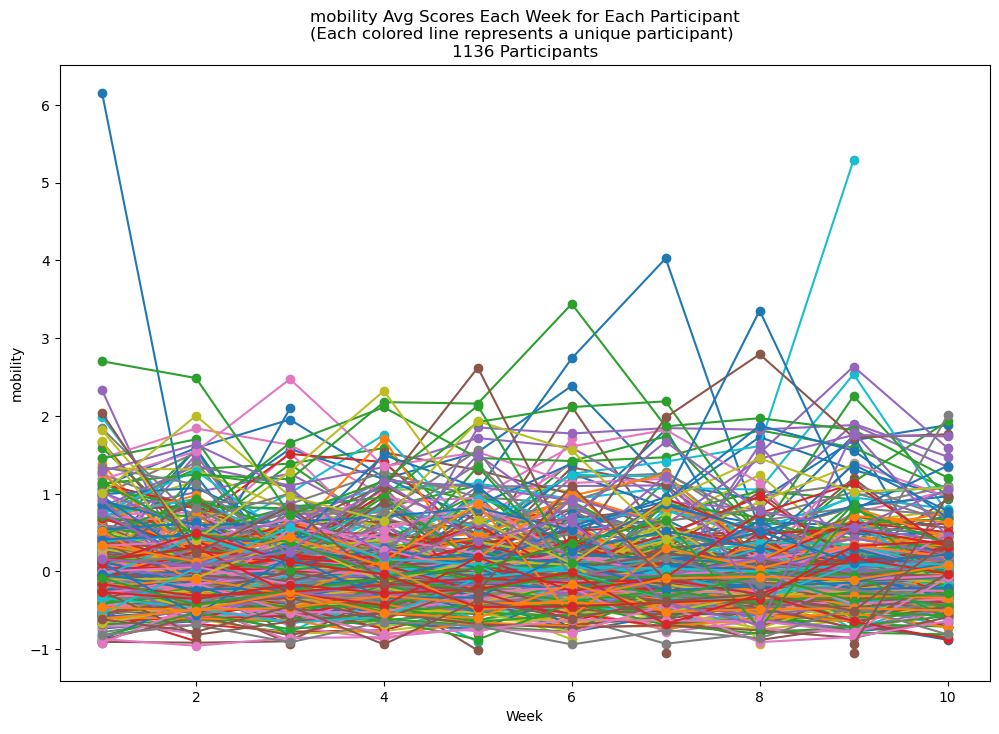

(1136, 44)


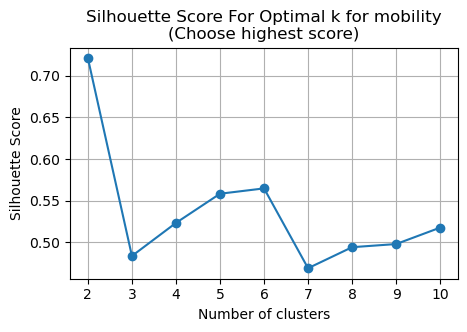

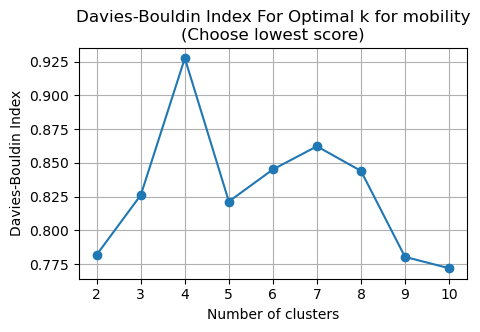

----------------v1_week----------------


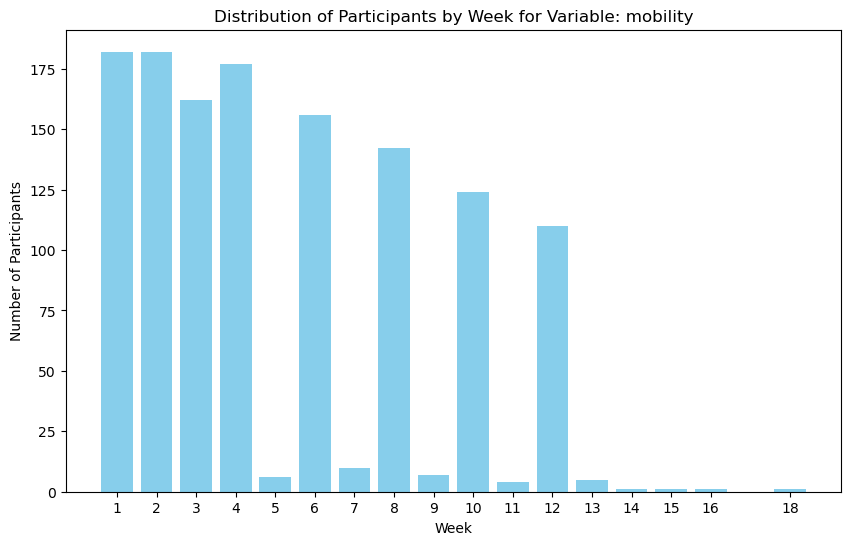

weeks found: [1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0]
Filtered DataFrame shape: (251, 18)


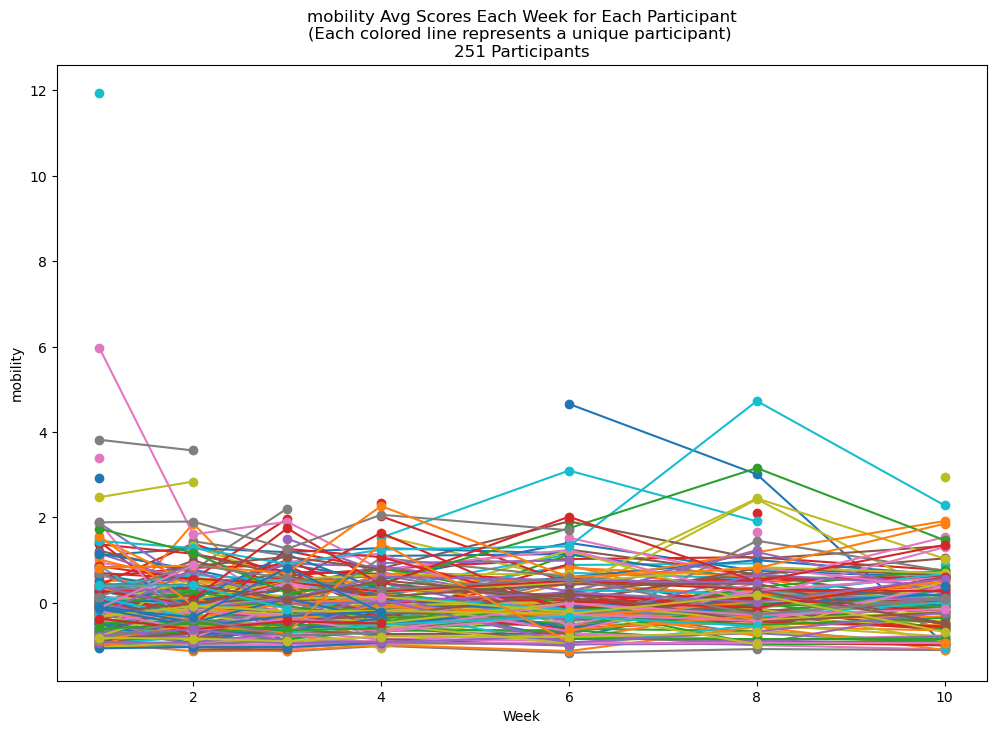

(251, 18)


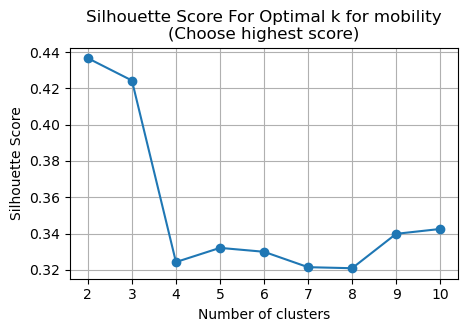

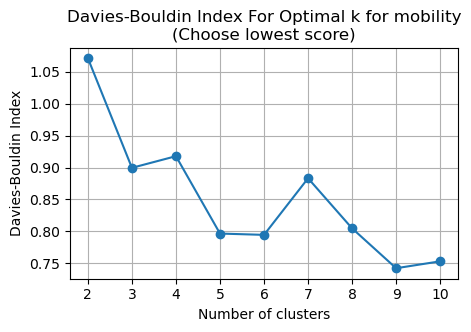

In [25]:
##### Cluster independent variables into high/low clusters
importlib.reload(cl)
### MULTI-TIME DTW DISTANCE MATRIX 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

# Step 0: Choose a Y-variable to cluster & import data
cluster_var = 'mobility' #choose y_col
cluster_label = 'mobility_cluster'
v1_day_weeks = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
v1_week_weeks = [1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0]

for name in df_names:
    if 'v1' in name:
        print(f'----------------{name}----------------')
        df = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
        # Display/chart cluster data
        if 'v1_day' in name:
            filtered_df = cl.process_cluster_data(df, cluster_var, v1_day_weeks)
        if 'v1_week' in name:
            filtered_df = cl.process_cluster_data(df, cluster_var, v1_week_weeks)
        print(filtered_df.shape)
        # Now do cluster analysis for different clusters' scores
        distance_matrix, embedding, results = cl.cluster_distance_analysis(filtered_df, required_weeks, cluster_var, n_clusters_range=range(1, 11))


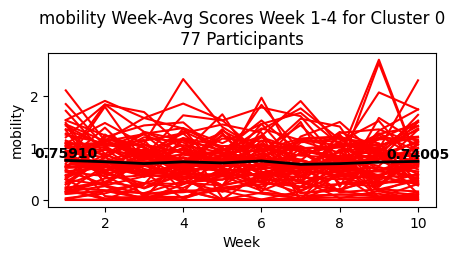

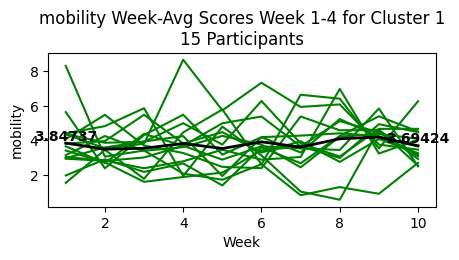

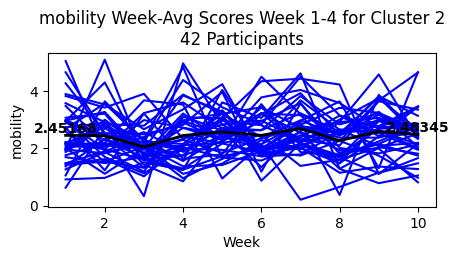

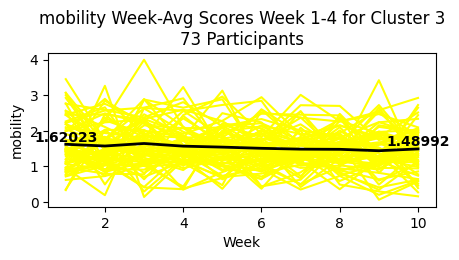

Cluster map for IDs to mobility_cluster (4 clusters) saved to mobility_cluster4_map.csv 


In [4]:
######### KMeans CLUSTERING for variable responses 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tslearn.metrics import cdist_dtw
from sklearn.cluster import DBSCAN
from tslearn.utils import to_time_series_dataset


# Step 1: Perform KMeans clustering
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(distance_matrix)

# Step 2: Add cluster labels to df
filtered_df[cluster_label] = kmeans.labels_
cluster_map = filtered_df[['num_id', cluster_label]].drop_duplicates()
cluster_df = df_alldays_int70.merge(cluster_map, on=['num_id'], how='left')


# Step 3: Visualize the clusters
colors = ['red', 'green', 'blue', 'yellow','orange','brown']

for c in range(n_clusters):
     # Create a new figure for each cluster
    fig, ax = plt.subplots(figsize=(5, 2))

    # Get indices of participants belonging to the current cluster
    cluster_indices = [i for i, label in enumerate(kmeans.labels_) if label == c]
    cluster_data = filtered_df[required_weeks].iloc[cluster_indices]
    
    # Plot each participant in the current cluster
    for i in cluster_indices:
        ax.plot(filtered_df[required_weeks].iloc[i], color=colors[c], label=f'Participant {i}' if i == cluster_indices[0] else "")
    
    # Plot the average for that cluster
    avg_line = cluster_data.mean(axis=0)  # Mean across rows for each week
    ax.plot(range(1, len(avg_line) + 1), avg_line, color='black', linewidth=2, label='Average')
    # Label the score at the beginning and end of the average line
    ax.text(1, avg_line.iloc[0], f"{avg_line.iloc[0]:.5f}", color='black', ha='center', va='bottom', fontweight='bold')
    ax.text(len(avg_line), avg_line.iloc[-1], f"{avg_line.iloc[-1]:.5f}", color='black', ha='center', va='bottom', fontweight='bold')
    
    # Add a legend with cluster labels and custom title
    ax.set_xlabel('Week')
    ax.set_ylabel(cluster_var)
    ax.set_title(f'{cluster_var} Week-Avg Scores Week 1-4 for Cluster {c}\n{len(cluster_indices)} Participants')
    
    # Show the plot for the current cluster
    plt.show()

cluster_map.to_csv(os.path.join(brighten_dir, f'{cluster_label}{n_clusters}_map.csv'))
print(f"Cluster map for IDs to {cluster_label} ({n_clusters} clusters) saved to {cluster_label}{n_clusters}_map.csv ")

phq9_sum in df
67 NOISE/low mobility_cluster participants
62 medium mobility_cluster participants
31 medium_high mobility_cluster participants
12 high mobility_cluster participants


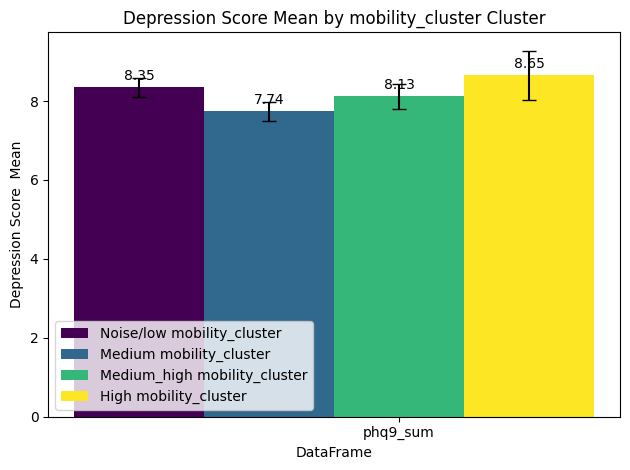

phq2_sum_int in df
67 NOISE/low mobility_cluster participants
64 medium mobility_cluster participants
31 medium_high mobility_cluster participants
12 high mobility_cluster participants


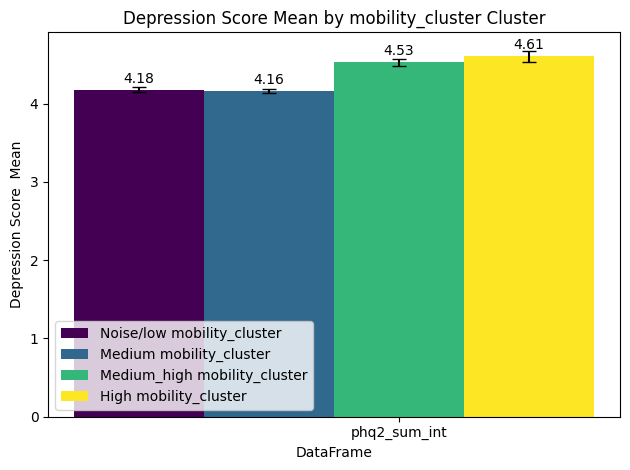

In [ ]:
#### Visualize distribution of certain variables for different clusters (KMeans)

# Dictionary to map cluster descriptions to cluster numbers
cluster_keys = {
    "NOISE/low": 0,
    #"medium_low": 3,
    "medium": 3,
    "medium_high": 2,
    "high":1
    # Add more mappings as needed, e.g., "med high": 0, "med": 1, "med low": 2, "low": 3
}
n_clusters = len(cluster_keys.keys())
# Initialize the cluster df by merging the cluster id-to-cluster mapping into the large df
cluster_map = pd.read_csv(os.path.join(brighten_dir, f'{cluster_label}{n_clusters}_map.csv'))
dfw_with_cluster = week_df_int70.merge(cluster_map, on=['num_id'], how='outer')

# Variable to compare
y_var, y_var_name = 'phq9_sum', 'Depression Score' #mood_1, sds_1, sds_2, sds_3, phq9_sum, phq2_sum
vis.plot_var_for_cluster(dfw_with_cluster, cluster_keys, cluster_var, cluster_label, y_var, y_var_name)

df_with_cluster = df_alldays_int70.merge(cluster_map, on=['num_id'], how='outer')
y_var, y_var_name = 'phq2_sum_int',  'Depression Score' #mood_1, sds_1, sds_2, sds_3, phq9_sum, phq2_sum
vis.plot_var_for_cluster(df_with_cluster, cluster_keys, cluster_var, cluster_label, y_var, y_var_name)


DTW distance matrix stats:
Min: 0.0
Max: 52.68671428571429
Mean: 10.904747777077645
eps: 1.75, clusters: 1, noise: 183
eps: 1.76, clusters: 1, noise: 183
eps: 1.76, clusters: 1, noise: 182
eps: 1.77, clusters: 1, noise: 182
eps: 1.77, clusters: 1, noise: 182
eps: 1.78, clusters: 1, noise: 182
eps: 1.78, clusters: 2, noise: 174
eps: 1.79, clusters: 2, noise: 174
eps: 1.79, clusters: 2, noise: 174
eps: 1.80, clusters: 2, noise: 174
eps: 1.80, clusters: 2, noise: 174
eps: 1.81, clusters: 2, noise: 174
eps: 1.81, clusters: 2, noise: 174
eps: 1.82, clusters: 2, noise: 174
eps: 1.82, clusters: 2, noise: 174
eps: 1.83, clusters: 1, noise: 174
eps: 1.83, clusters: 1, noise: 171
eps: 1.84, clusters: 1, noise: 171
eps: 1.84, clusters: 1, noise: 170
eps: 1.85, clusters: 1, noise: 170


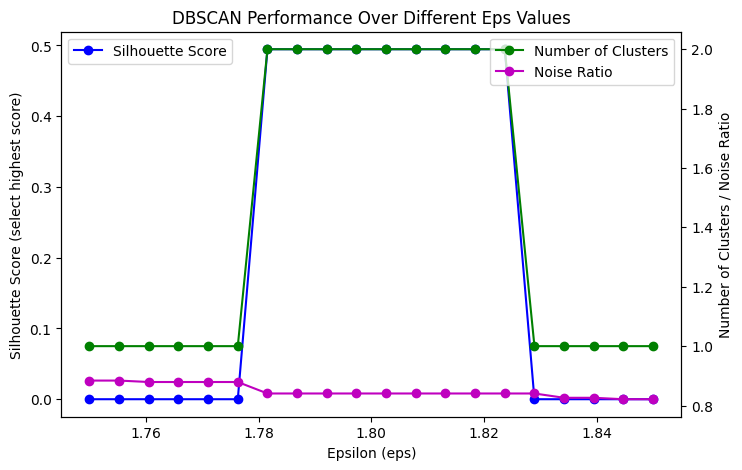

In [122]:
dtw_matrix, embedding, results = cl.cluster_dtw_analysis(filtered_df, required_weeks, eps_values=np.linspace(1.75, 1.85, 20), min_samples=10, verbose=True)

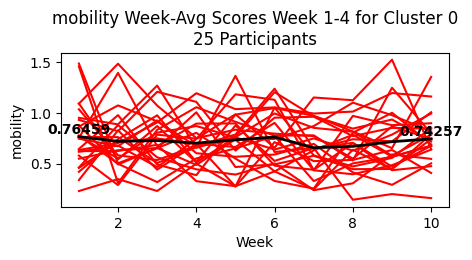

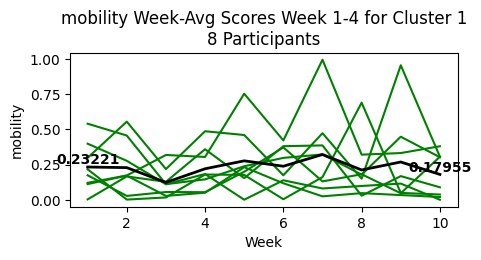

Cluster map for IDs to mobility_cluster (2 clusters) saved to mobility_cluster2_dbscan_map.csv 


In [123]:
######### DBSCAN CLUSTERING for variable responses 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tslearn.metrics import cdist_dtw
from sklearn.cluster import DBSCAN
from tslearn.utils import to_time_series_dataset


# Step 1: Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.81, min_samples=10, metric='precomputed')
labels = dbscan.fit_predict(dtw_matrix)

# Count clusters (excluding noise)
unique_labels = set(labels) - {-1}
n_clusters = len(unique_labels)

# Add cluster labels to df 
filtered_df[cluster_label] = labels
cluster_map_dtw = filtered_df[['num_id', cluster_label]].drop_duplicates()
cluster_df = df_alldays_int70.merge(cluster_map_dtw, on=['num_id'], how='left')


# Step 3: Visualize the clusters
colors = ['red', 'green', 'blue', 'yellow','orange','brown']

for c in range(n_clusters):
     # Create a new figure for each cluster
    fig, ax = plt.subplots(figsize=(5, 2))

    # Get indices of participants belonging to the current cluster
    cluster_indices = [i for i, label in enumerate(labels) if label == c]
    cluster_data = filtered_df[required_weeks].iloc[cluster_indices]
    
    # Plot each participant in the current cluster
    for i in cluster_indices:
        ax.plot(filtered_df[required_weeks].iloc[i], color=colors[c], label=f'Participant {i}' if i == cluster_indices[0] else "")
    
    # Plot the average for that cluster
    avg_line = cluster_data.mean(axis=0)  # Mean across rows for each week
    ax.plot(range(1, len(avg_line) + 1), avg_line, color='black', linewidth=2, label='Average')
    # Label the score at the beginning and end of the average line
    ax.text(1, avg_line.iloc[0], f"{avg_line.iloc[0]:.5f}", color='black', ha='center', va='bottom', fontweight='bold')
    ax.text(len(avg_line), avg_line.iloc[-1], f"{avg_line.iloc[-1]:.5f}", color='black', ha='center', va='bottom', fontweight='bold')
    
    # Add a legend with cluster labels and custom title
    ax.set_xlabel('Week')
    ax.set_ylabel(cluster_var)
    ax.set_title(f'{cluster_var} Week-Avg Scores Week 1-4 for Cluster {c}\n{len(cluster_indices)} Participants')
    
    # Show the plot for the current cluster
    plt.show()

cluster_map_dtw.to_csv(os.path.join(brighten_dir, f'{cluster_label}{n_clusters}_dbscan_map.csv'))
print(f"Cluster map for IDs to {cluster_label} ({n_clusters} clusters) saved to {cluster_label}{n_clusters}_dbscan_map.csv ")

phq9_sum in df
20 low mobility_cluster participants
6 high mobility_cluster participants


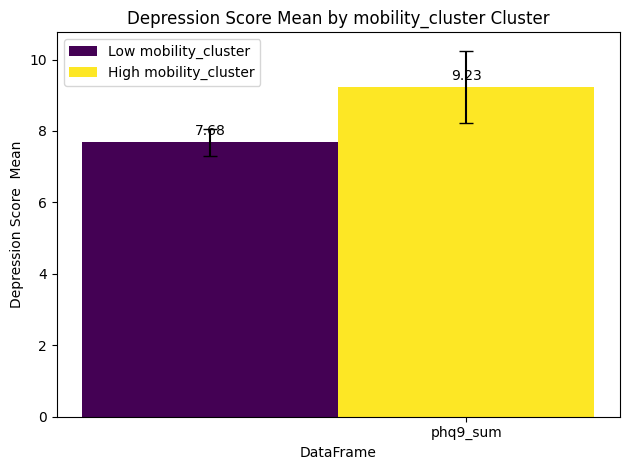

phq2_sum_int in df
20 low mobility_cluster participants
6 high mobility_cluster participants


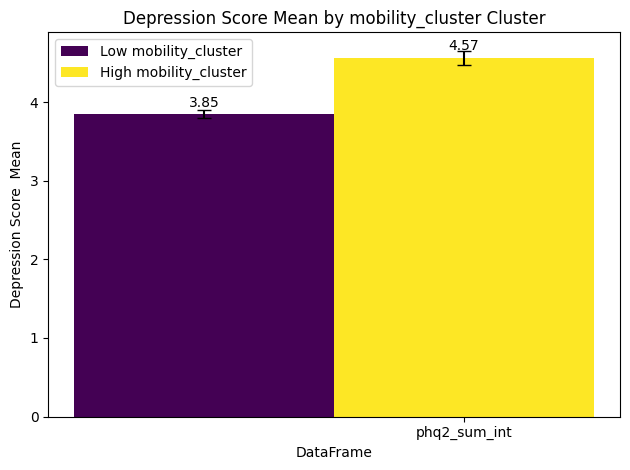

In [124]:
#### Visualize distribution of certain variables for different clusters (DBSCAN)

# Initialize the cluster df by merging the cluster id-to-cluster mapping into the large df
cluster_keys = {
    "low": 0,
    "high": 1,
    # Add more mappings as needed, e.g., "med high": 0, "med": 1, "med low": 2, "low": 3
}
cluster_map = pd.read_csv(os.path.join(brighten_dir, f'{cluster_label}{n_clusters}_dbscan_map.csv'))
dfw_with_cluster = week_df_int70.merge(cluster_map, on=['num_id'], how='outer')

# Variable to compare
y_var, y_var_name = 'phq9_sum', 'Depression Score' #mood_1, sds_1, sds_2, sds_3, phq9_sum, phq2_sum
vis.plot_var_for_cluster(dfw_with_cluster, cluster_keys, cluster_var, cluster_label, y_var, y_var_name)

df_with_cluster = df_alldays_int70.merge(cluster_map, on=['num_id'], how='outer')
y_var, y_var_name = 'phq2_sum_int',  'Depression Score' #mood_1, sds_1, sds_2, sds_3, phq9_sum, phq2_sum
vis.plot_var_for_cluster(df_with_cluster, cluster_keys, cluster_var, cluster_label, y_var, y_var_name)


In [ ]:
# ##### Cluster subjects into network subtypes
# #### Save each sub's V1 symptom correlation distance matrix into v1_symptom_matrices

# def flatten_matrix(corr_matrix):
#     indices = []
#     for i in range(corr_matrix.shape[0]):
#         for j in range(i, corr_matrix.shape[1]):
#             if not i==j:
#                 indices.append([i,j])
#     return [corr_matrix.iloc[row, col] for row, col in indices]

# def upper_triangle(corr_matrix):
#     indices = []
#     for i in range(corr_matrix.shape[0]):
#         for j in range(i, corr_matrix.shape[1]):
#             if not i==j:
#                 indices.append([i,j])
#     return indices

# for name, df in d
# #full_df_v1 = full_df_v1.drop(columns='aggregate_communication_scaled')
# subs = full_df_v1['num_id'].unique()
# print(f'In full_dt_v1 there are {len(subs)} subjects.')

# flattened_sub_matrices = {}
# v1_symptom_matrices = {}
# subs2 = []
# for sub in subs:
#     data = full_df_v1[full_df_v1['num_id']==sub] # filter for each specific sub
#     # keep only numerical/changing columns
#     keep_columns = [var for var in full_df_v1.columns.to_list() if var.startswith('pc_')]
#     data = data[keep_columns] 
#     # transform into correlation matrix
#     correlation_matrix = data.corr() 
#     # Replace inf/-inf with NaN
#     correlation_matrix = correlation_matrix.replace([float('inf'), -float('inf')], pd.NA)  
#     # drop resulting NaNs
#     correlation_matrix = correlation_matrix.dropna() 
#     # add subs with non-empty matrices to subs2
#     if not correlation_matrix.empty:
#         subs2.append(sub) 
#          # add entire corr matrix to list
#         v1_symptom_matrices[sub] = correlation_matrix
#         # extract unique values from upper triangle into vector
#         vector = flatten_matrix(correlation_matrix) 
#          # add nonzero vector to list
#         if not len(vector)==0:
#             flattened_sub_matrices[sub] = vector

#         # # Heatmap
#         # plt.figure(figsize=(2, 1))
#         # sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.1f', linewidths=0.5)
#         # plt.title(f"{sub}")
#         # plt.show()

#     #     # Line/Scatter plot
#     #     x = np.arange(len(vector))
#     #     plt.figure(figsize=(2, 1))
#     #     plt.scatter(x, vector, label="Points", color="blue")

    
# # plt.show()


# print(len(flattened_sub_matrices.keys()), 'filled arrays')


# linkage_matrix = linkage(list(flattened_sub_matrices.values()), method='ward', metric='euclidean')
# dendrogram(linkage_matrix, labels=list(flattened_sub_matrices.keys()))
# plt.show()



In [39]:

# # Step 5: Perform clustering of subjects
# num_clusters = 5
# hierarchical_cluster = AgglomerativeClustering(
#     n_clusters=num_clusters,  # Number of clusters
#     linkage='ward'  # Linkage method
# )

# labels = hierarchical_cluster.fit_predict(linkage_matrix)
# print(labels)

# sub_clusters = dict(zip(flattened_sub_matrices.keys(), labels))